In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *

import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.AUTOTUNE

init = tf.keras.initializers.RandomNormal(stddev=0.02)

In [ ]:
TRAIN = "/content/drive/MyDrive/city_shades/data/train/*"
TEST = "/content/drive/MyDrive/city_shades/data/val/*"

In [ ]:
list_train = tf.data.Dataset.list_files(TRAIN, shuffle=True)
list_test = tf.data.Dataset.list_files(TEST, shuffle=False)

print(tf.data.experimental.cardinality(list_train).numpy())
print(tf.data.experimental.cardinality(list_test).numpy())

2975
540


In [ ]:
def decode_img(img):
    img = tf.io.read_file(img)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (256,512))
    
    input_img, target_img = img[:,:256], img[:,256:]
    # Normalize
    input_img, target_img = normalize(input_img, target_img)
    # Convert to float32
    input_img = tf.cast(input_img, tf.float32)
    target_img = tf.cast(target_img, tf.float32)
    return target_img, input_img


def normalize(input_img, target_img):
    input_img = input_img / 127.5 - 1
    target_img = target_img / 127.5 - 1
    return input_img, target_img

def denormalize(img):
    img = (img + 1) * 127.5
    return img

In [ ]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, 256, 256, 3])

    return cropped_image[0], cropped_image[1]

@tf.function()
def random_jitter(input_img, target_img):
    target_img, input_img = resize(input_img, target_img, 286, 286)
    target_img, input_img = random_crop(input_img, target_img)

    if tf.random.uniform(()) > 0.5:
        target_img = tf.image.flip_left_right(target_img)
        input_img = tf.image.flip_left_right(input_img)

    return input_img, target_img

In [ ]:
train_ds = list_train.map(decode_img, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(random_jitter, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(1)
train_ds = train_ds.prefetch(AUTOTUNE)
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [ ]:
test_ds = list_test.map(decode_img, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(1)
test_ds = test_ds.prefetch(AUTOTUNE)
test_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

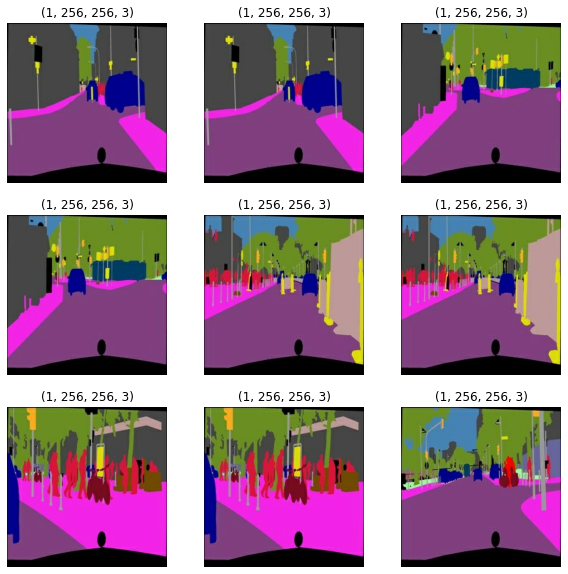

In [ ]:
plt.figure(figsize=(10, 10))
counter = 0
for sat, map_ in test_ds:
    plt.subplot(3, 3, counter + 1)
    plt.imshow(np.squeeze(sat) * 0.5 + 0.5)
    plt.title(sat.shape)
    plt.axis("off")
    counter+=1
    if counter==9: break

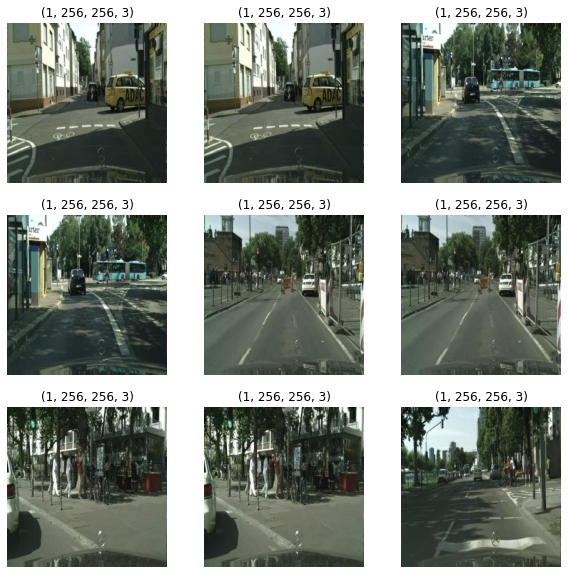

In [ ]:
plt.figure(figsize=(10, 10))
counter = 0
for sat, map_ in test_ds:
    plt.subplot(3, 3, counter + 1)
    plt.imshow(np.squeeze(map_)* 0.5 + 0.5)
    plt.title(sat.shape)
    plt.axis("off")
    counter+=1
    if counter==9: break

In [ ]:
def Discriminator(image_shape):
    image = Input(shape=image_shape)    # sat images
    target = Input(shape=image_shape)   # map
    
    concat = Concatenate()([image, target])
    
    x = Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(concat)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(256, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(512, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(1, kernel_size=(4,4), padding='same', kernel_initializer=init)(x)
    x = Activation('sigmoid')(x)
    
    model = Model([image, target], x)
    return model

In [ ]:
Discriminator = Discriminator((256,256,3))
Discriminator.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_18 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_30 (Concatenate)   (None, 256, 256, 6)  0           ['input_17[0][0]',               
                                                                  'input_18[0][0]']        

In [ ]:
def encoder(inputs, filters, batch_norm=True):
    x = Conv2D(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputs)
    if batch_norm:
        x = BatchNormalization()(x, training=True)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def decoder(inputs, skip, filters, dropout=True):
    x = Conv2DTranspose(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputs)
    x = BatchNormalization()(x, training=True)
    if dropout:
        x = Dropout(0.5)(x, training=True)
    x = Concatenate()([x, skip])
    x = Activation('relu')(x)
    return x

In [ ]:
def Generator(input_shape):
    inputs = Input(shape=input_shape)
    
    x1 = encoder(inputs, 64, batch_norm=False)
    x2 = encoder(x1, 128)
    x3 = encoder(x2, 256)
    x4 = encoder(x3, 512)
    x5 = encoder(x4, 512)
    x6 = encoder(x5, 512)
    x7 = encoder(x6, 512)
    
    x = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x7)
    x = ReLU()(x)
    
    y1 = decoder(x, x7, 512)
    y2 = decoder(y1, x6, 512)
    y3 = decoder(y2, x5, 512)
    y4 = decoder(y3, x4, 512, dropout=False)
    y5 = decoder(y4, x3, 256, dropout=False)
    y6 = decoder(y5, x2, 128, dropout=False)
    y7 = decoder(y6, x1, 64, dropout=False)
    
    x_new = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(y7)
    x_new = tf.keras.activations.tanh(x_new)
    
    model = Model(inputs, x_new)
    return model

In [ ]:
Generator = Generator((256,256,3))
Generator.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_71 (Conv2D)             (None, 128, 128, 64  3136        ['input_19[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_50 (LeakyReLU)     (None, 128, 128, 64  0           ['conv2d_71[0][0]']              
                                )                                                          

In [ ]:
generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
mae = tf.keras.losses.MeanAbsoluteError()

In [ ]:
#Generator Losses
def Generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_fn(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = mae(target, gen_output)
    gen_loss = gan_loss + (100 * l1_loss)
    return gen_loss

In [ ]:
#Discrimantor Losses
def Discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_fn(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_fn(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [ ]:
@tf.function()
def train_step(input_img, target_img):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #Generating images using input_images(fake)
        generated = Generator(input_img, training=True)
        
        disc_real = Discriminator([input_img, target_img], training=True)
        disc_generated = Discriminator([input_img, generated], training=True)
        
        #Generator Loss
        gen_total_loss = Generator_loss(disc_generated, generated, target_img)
        
        #Discriminator Loss
        Disc_loss = Discriminator_loss(disc_real, disc_generated)
        
    generator_gradients = gen_tape.gradient(gen_total_loss, Generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, Generator.trainable_variables))
    
    discriminator_gradients = disc_tape.gradient(Disc_loss, Discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, Discriminator.trainable_variables))
    
    return gen_total_loss, Disc_loss

In [ ]:
generator_loss = []
discriminator_loss = []

for epoch in range(100):
    for sat_img, map_img in train_ds.take(2000):
        gen_loss, disc_loss = train_step(sat_img, map_img)
        generator_loss.append(gen_loss), discriminator_loss.append(disc_loss)
        
    if epoch%10 == 0:
        print(f"Epochs:{epoch} || Generator_Loss: {gen_loss:.3f} || Discriminator_Loss: {disc_loss:.3f}")

Epochs:0 || Generator_Loss: 19.896 || Discriminator_Loss: 0.414
Epochs:10 || Generator_Loss: 32.121 || Discriminator_Loss: 0.832
Epochs:20 || Generator_Loss: 24.876 || Discriminator_Loss: 0.295
Epochs:30 || Generator_Loss: 19.672 || Discriminator_Loss: 2.994
Epochs:40 || Generator_Loss: 38.511 || Discriminator_Loss: 0.038
Epochs:50 || Generator_Loss: 16.760 || Discriminator_Loss: 0.565
Epochs:60 || Generator_Loss: 21.248 || Discriminator_Loss: 0.780
Epochs:70 || Generator_Loss: 19.237 || Discriminator_Loss: 0.288
Epochs:80 || Generator_Loss: 16.002 || Discriminator_Loss: 0.736
Epochs:90 || Generator_Loss: 22.927 || Discriminator_Loss: 0.254


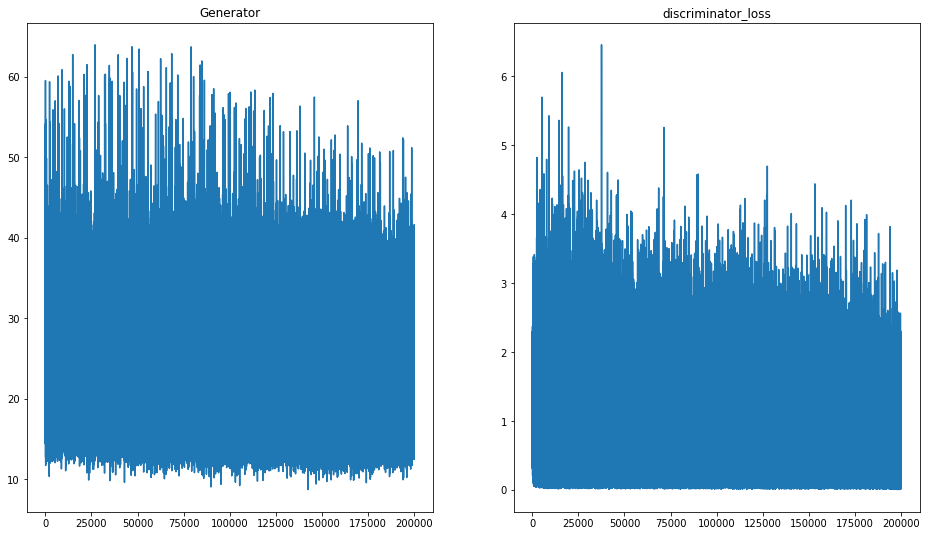

In [ ]:
plt.figure(figsize=(16,9))
plt.subplot(121), plt.plot(generator_loss), plt.title('Generator')
plt.subplot(122), plt.plot(discriminator_loss), plt.title("discriminator_loss")
plt.show()

In [ ]:
Generator.save("/content/drive/MyDrive/city_shades/gen.h5")
Discriminator.save("/content/drive/MyDrive/city_shades/dis.h5")

In [ ]:
Generator.save("/content/drive/MyDrive/city_shades/generator/")
Discriminator.save("/content/drive/MyDrive/city_shades/dis/")

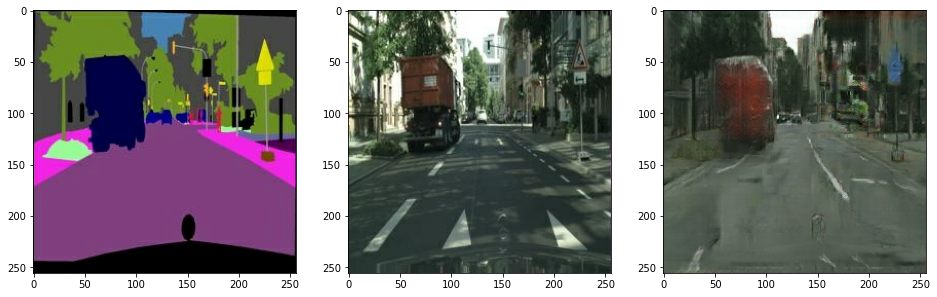

In [ ]:
x, y = decode_img("/content/drive/MyDrive/city_shades/data/val/124.jpg")
preds = Generator.predict(tf.expand_dims(x, axis=0))

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))
plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(133), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))
plt.show()

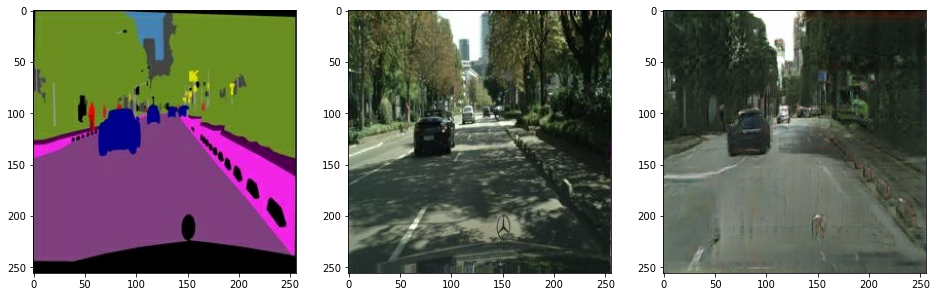

In [ ]:
x, y = decode_img("/content/drive/MyDrive/city_shades/data/val/159.jpg")
preds = Generator.predict(tf.expand_dims(x, axis=0))

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))
plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(133), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))
plt.show()

In [ ]:
x, y = decode_img("/content/drive/MyDrive/city_shades/data/val/138.jpg")
preds = Generator.predict(tf.expand_dims(x, axis=0))

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))
plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(133), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))
plt.show()